# 003.02 Features - Stack and try Modeling

In [1]:
import pathlib
import sys

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.mlab as mlab
import seaborn as sns

%matplotlib inline

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1
#add the 'src' directory to path to import modules
PROJECT_DIR = pathlib.Path.cwd().resolve().parent
sys.path.append(str(PROJECT_DIR))

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

DATA_DIR = PROJECT_DIR / 'data'
PROCESSED_DATA_DIR = DATA_DIR / '04-processed'

In [2]:
league = 'english-premier-league'
seasons = ['2009-2010', '2010-2011','2011-2012']


In [3]:
def rps_mean(estimator, X: np.ndarray, y: np.ndarray) -> float:
    """
    https://scikit-learn.org/stable/modules/model_evaluation.html#implementing-your-own-scoring-object
    Accepts:
    a scikit learn estimator model - estimator must have a predict_proba method
    X - data used to make prediction - validation data
    y = ground truth
    
    !!!!!!!!!!!
    """
    # Convert the y to a one hot encoded DataFrame in same sequence as prediction probas
    
    # Deal with situation where all classes not in y
    # Get the missing classes
    missing_classes = set(estimator.classes_) - set(np.unique(y))
    # Get ys as a DataFrame
    y_encoded = pd.get_dummies(y)
    if missing_classes:
        for missing_class in missing_classes:
            # Insert missing class into y encoded as 0
            y_encoded[missing_class] = 0
            
    # Put y matrix into the same column order as the probability predictions
    y_encoded = y_encoded[estimator.classes_]
        
    # Get the probabilities into a DataFrame
    pred_df = pd.DataFrame(estimator.predict_proba(X))
    
    # Cumulative Distributions
    pred_cdf = pd.DataFrame(pred_df).cumsum(axis='columns').values
    obs_cdf = y_encoded.cumsum(axis='columns').values
    # RPS Calculation and get sum
    # each prediction set could be a different length, so divide the sum by the number of pred observations
    #RPS = pd.Series(np.sum(1/(pred_df.shape[1]-1) * (pred_cdf - obs_cdf)**2, 1), name='RPS').sum()/len(y)
    mean_RPS = pd.Series(np.sum(1/(pred_df.shape[1]-1) * (pred_cdf - obs_cdf)**2, 1), name='RPS').mean()
    # Negate return because for RPS lower is better, but for sklearn scorer higher is better
    return -mean_RPS

In [4]:
# import re

def get_n_past_games(df_orig, past_games=2, dropna_rows=True):
    """
    Restrict historical records to the last n games
    If n = 2, then will get
    home team
        last 2 games played at home ie. h_h_feature-1, h_h_feature-2
        last 2 games played away ie h_a_feature-1, h_a_feature-2
    away team
        last 2 games played at home ie a_h_feature-1, a_h_feature-2
        last 2 games played away ie a_a_feature-1, a_a_feature-2
    where -1 is the most recent game prior to the current game, and -2 is the game before that
    the current games result is in result
    """
    df = df_orig.copy(deep=True)
    keeper_cols = [col for col in df.columns if not col.split('_')[-1].isalpha() \
               and int(col.split('_')[-1]) > -(past_games+1) \
               or col.isalpha() \
               or 'odds' in col]
    keeper_cols = keeper_cols + ['result']#, 'h_ftgoals', 'a_ftgoals']
    
#     # Rename the target columns to start with prefix 'res_'
#     res_cols = [col for col in df.columns if not col.split('_')[-1].isalpha() \
#                 and int(col.split('_')[-1]) == 0]
#     res_cols.append('result')
#     res_cols = [col.replace('0', 'res') for col in res_cols]
#     print(res_cols)
#     print(res_cols)
    df = df[keeper_cols]
    return df

# df_load = pd.read_csv(save_fp, parse_dates = ['date'], index_col=None) 
# df_cut = get_n_past_games(df_load)
# # # Restrict Historical records to last 4 games per team
# # df_cut = df_load.copy(deep=True)
# # hist_games = 2
# # keeper_cols = [col for col in df.columns if not col.split('_')[-1].isalpha() \
# #                and int(col.split('_')[-1]) > -(hist_games+1) \
# #                and int(col.split('_')[-1]) < 0 \
# #                or col.isalpha() \
# #                or 'odds' in col]
# # df_cut = df_cut[keeper_cols]
# df_cut.head()

In [5]:
season_dfs= []
for season in seasons:
    load_fp = PROCESSED_DATA_DIR / league / season / str(league + '--' + season + '.csv')
    season_df = pd.read_csv(load_fp, parse_dates = ['date'], index_col=None)
    season_df = get_n_past_games(season_df)
    season_df.dropna(subset=['h_h_shots_-2', 'a_a_shots_-2', 'h_a_shots_-2', 'a_h_shots_-2'], inplace=True)
    season_dfs.append(season_df)
#~season_df.head()
# Have got 2 results columns - drop duplicates

df = pd.concat(season_dfs, axis=0).reset_index(drop=True).sort_values(by=['date'])
df = df.loc[:,~df.columns.duplicated()]
df.head()

,season,date,h,a,h_h_shots_-1,h_h_shots_-2,result,a_a_shots_-1,a_a_shots_-2,a_h_shots_-1,a_h_shots_-2,h_a_shots_-1,h_a_shots_-2
0,2009-2010,2009-09-12,liverpool,burnley,21.0,18.0,hwin,3.0,9.0,8.0,8.0,26.0,6.0
1,2009-2010,2009-09-12,stoke-city,chelsea,13.0,12.0,awin,12.0,20.0,27.0,26.0,13.0,6.0
2,2009-2010,2009-09-12,tottenham-hotspur,manchester-united,20.0,17.0,awin,16.0,18.0,10.0,26.0,17.0,18.0
3,2009-2010,2009-09-12,sunderland,hull-city,8.0,4.0,hwin,5.0,7.0,12.0,9.0,9.0,20.0
4,2009-2010,2009-09-19,aston-villa,portsmouth,9.0,11.0,hwin,9.0,9.0,21.0,11.0,12.0,7.0


In [6]:
df.tail()

,season,date,h,a,h_h_shots_-1,h_h_shots_-2,result,a_a_shots_-1,a_a_shots_-2,a_h_shots_-1,a_h_shots_-2,h_a_shots_-1,h_a_shots_-2
1001,2011-2012,2012-05-13,manchester-city,queens-park-rangers,12.0,17.0,hwin,11.0,16.0,21.0,12.0,19.0,17.0
1000,2011-2012,2012-05-13,chelsea,blackburn-rovers,17.0,25.0,hwin,0.0,7.0,12.0,9.0,9.0,13.0
999,2011-2012,2012-05-13,wigan-athletic,wolverhampton-wanderers,10.0,11.0,hwin,15.0,12.0,7.0,7.0,19.0,9.0
1002,2011-2012,2012-05-13,norwich-city,aston-villa,8.0,16.0,hwin,8.0,10.0,4.0,17.0,12.0,12.0
1008,2011-2012,2012-05-13,everton,newcastle-united,11.0,22.0,hwin,12.0,11.0,14.0,16.0,18.0,11.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1009 entries, 0 to 1008
Data columns (total 13 columns):
season          1009 non-null object
date            1009 non-null datetime64[ns]
h               1009 non-null object
a               1009 non-null object
h_h_shots_-1    1009 non-null float64
h_h_shots_-2    1009 non-null float64
result          1009 non-null object
a_a_shots_-1    1009 non-null float64
a_a_shots_-2    1009 non-null float64
a_h_shots_-1    1009 non-null float64
a_h_shots_-2    1009 non-null float64
h_a_shots_-1    1009 non-null float64
h_a_shots_-2    1009 non-null float64
dtypes: datetime64[ns](1), float64(8), object(4)
memory usage: 110.4+ KB


In [8]:
df1 = df.copy(deep=True)

X = df1[['h_h_shots_-1', 'h_h_shots_-2', 'a_a_shots_-1', 'a_a_shots_-2',
         'a_h_shots_-1', 'a_h_shots_-2', 'h_a_shots_-1', 'h_a_shots_-2', 'result']]
y_str = X.pop('result')
print(y_str[0:10])

from sklearn.preprocessing import LabelEncoder
from skoot.preprocessing import SelectiveMinMaxScaler
#from sklearn.utils.multiclass import type_of_target
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y_str)
skf = StratifiedKFold(n_splits=5)
print(y[0:10])

# n_games 1140
# hwin    0.476316
# draw    0.263158
# awin    0.260526
# Name: result, dty

model = GaussianNB(priors=[0.29, 0.26, 0.45])
model = MultinomialNB(class_prior=[0.29, 0.26, 0.45])
model = ComplementNB(class_prior=[0.29, 0.26, 0.45])
model = LogisticRegression(class_weight='balanced')
model = SGDClassifier(loss='log', class_weight='balanced')
model = SVC(probability=True, class_weight='balanced', C=100)

pipe = Pipeline([('scaler', SelectiveMinMaxScaler()),
                ('model', model)])

    


proba = cross_val_predict(pipe, X, y, cv=skf, method='predict_proba')

print(proba)

0    hwin
1    awin
2    awin
3    hwin
4    hwin
5    draw
6    hwin
7    awin
8    hwin
9    hwin
Name: result, dtype: object
[2 0 0 2 2 1 2 0 2 2]


/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/david/anac

[[0.16016003 0.33342205 0.50641792]
 [0.34280658 0.32011363 0.33707978]
 [0.22683956 0.26321549 0.50994495]
 ...
 [0.16242025 0.19836414 0.63921561]
 [0.20136868 0.23712635 0.56150497]
 [0.22236901 0.21901739 0.5586136 ]]


/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [9]:
proba.shape

(1009, 3)

In [10]:
model.fit(X, y)
proba = model.predict_proba(X)
classes = model.classes_
classes

/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([0, 1, 2])

In [16]:
cols = ['awin', 'draw', 'hwin']
probas = pd.DataFrame(proba, columns=cols)
full_df = pd.concat([df, probas], axis=1)
full_df['pred'] = full_df[cols].idxmax(axis=1)
full_df.head(20)

,season,date,h,a,h_h_shots_-1,h_h_shots_-2,result,a_a_shots_-1,a_a_shots_-2,a_h_shots_-1,a_h_shots_-2,h_a_shots_-1,h_a_shots_-2,awin,draw,hwin,pred
0,2009-2010,2009-09-12,liverpool,burnley,21.0,18.0,hwin,3.0,9.0,8.0,8.0,26.0,6.0,0.077216,0.178626,0.744158,hwin
1,2009-2010,2009-09-12,stoke-city,chelsea,13.0,12.0,awin,12.0,20.0,27.0,26.0,13.0,6.0,0.666045,0.239815,0.094139,awin
2,2009-2010,2009-09-12,tottenham-hotspur,manchester-united,20.0,17.0,awin,16.0,18.0,10.0,26.0,17.0,18.0,0.666016,0.239833,0.094151,awin
3,2009-2010,2009-09-12,sunderland,hull-city,8.0,4.0,hwin,5.0,7.0,12.0,9.0,9.0,20.0,0.077258,0.178618,0.744125,hwin
4,2009-2010,2009-09-19,aston-villa,portsmouth,9.0,11.0,hwin,9.0,9.0,21.0,11.0,12.0,7.0,0.077224,0.178695,0.744081,hwin
5,2009-2010,2009-09-19,bolton-wanderers,stoke-city,8.0,11.0,draw,13.0,6.0,4.0,13.0,14.0,20.0,0.206235,0.497225,0.296540,draw
6,2009-2010,2009-09-19,burnley,sunderland,8.0,8.0,hwin,9.0,20.0,7.0,8.0,6.0,3.0,0.077266,0.178612,0.744122,hwin
7,2009-2010,2009-09-19,hull-city,birmingham-city,12.0,9.0,awin,11.0,6.0,11.0,8.0,6.0,5.0,0.665677,0.240216,0.094107,awin
8,2009-2010,2009-09-20,chelsea,tottenham-hotspur,27.0,26.0,hwin,17.0,18.0,11.0,20.0,18.0,12.0,0.077207,0.178619,0.744174,hwin
9,2009-2010,2009-09-20,wolverhampton-wanderers,fulham,24.0,19.0,hwin,6.0,9.0,14.0,4.0,9.0,10.0,0.077280,0.178674,0.744046,hwin


In [12]:
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(full_df['result'], full_df['pred']))
df_cm

,0,1,2
0,171,27,57
1,19,190,61
2,65,53,366


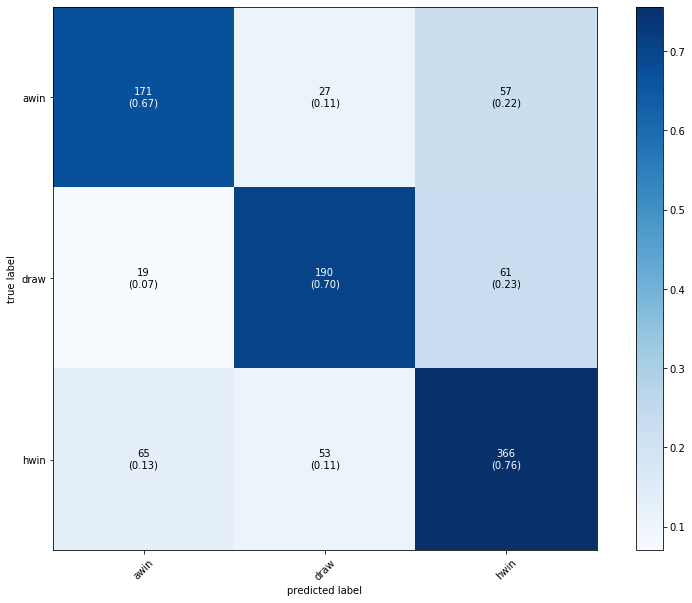

In [13]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=df_cm.values,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                               class_names=cols, figsize=(14,10))
plt.show();

In [14]:
rps_mean(model, X, y)

-0.049798138741443496

In [15]:
from joblib import dump, load
dump(model, 'svc.joblib')

['svc.joblib']